In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [46]:
team_records_initial = pd.read_csv('records.csv')[['year','team','team_wins','team_losses','team_ties','playoffs']]
#team_records = team_records[['year','team','team_wins','team_losses','team_ties']]
df_initial = pd.read_csv('bref.csv')

In [47]:
master_org_dict = {'MON':'WSN',
                   'CAL':'LAA',
                   'WSA':'TEX',
                   'SEP':'MIL',
                   'KCA':'OAK',
                   'MLN':'ATL',
                   'FLA':'MIA',
                   'TBD':'TBR',
                   'WSH':'MIN',
                   'NYG':'SFG',
                   'BRO':'LAD',
                   'PHA':'OAK',
                   'SLB':'BAL',
                   'BSN':'ATL',
                   'ANA':'LAA'
                  }

recs = team_records_initial.copy()
recs['master_team'] = recs['team'].apply(lambda x: master_org_dict[x] if x in master_org_dict else x)
recs2 = recs.copy()
for col in ['team_wins','team_losses','team_ties']:
    recs2 = recs2.rename(columns={col:'%s_prior_year' % col})
recs2['year'] = recs2['year'] + 1
    
recs = pd.merge(recs,recs2,on=['year','team','playoffs','master_team'],how='left')

In [48]:
def adjust_data_frame(data_frame):
    for val in ['','_prior_year']:
        win_col = 'team_wins%s' % val
        loss_col = 'team_losses%s' % val
        tie_col = 'team_ties%s' % val
        
        data_frame['team_games_played%s' % val] = data_frame[win_col] + data_frame[loss_col] + data_frame[tie_col]
        data_frame['team_win_pct%s' % val] = data_frame[win_col] / (data_frame[loss_col] + data_frame[win_col])
    data_frame['decade'] = data_frame['year'].apply(lambda x: str(x)[:3] + '0s')
    for col in ['wins','saves']:
        data_frame[col] = data_frame[col].fillna(0)
    data_frame['wins_saves'] = data_frame['wins'] + data_frame['saves']
    data_frame = data_frame.loc[data_frame.voting_place<=20,:]
    data_frame = data_frame.loc[data_frame.wins_saves==0,:]
    data_frame['wins_improvement'] = data_frame['team_wins'] + data_frame['team_wins_prior_year']
    data_frame['win_pct_improvement'] = data_frame['team_win_pct'] + data_frame['team_win_pct_prior_year']
    data_frame['runs_produced'] = data_frame['runs'] + data_frame['rbi'] - data_frame['home_runs']
    return data_frame

In [59]:
df = df_initial.copy()
df = pd.merge(df,recs,on=['team','year'],how='left')
df = adjust_data_frame(df)
#df = df.sort_values(['year','league','points'],ascending=False).reset_index()
max_year_df = df[['year','league','voting_place']].groupby(['year','league']).min().reset_index()
max_year_df = max_year_df.rename(columns={'voting_place':'max_finish'})
df = pd.merge(df,max_year_df,on=['year','league'],how='left')
df['winner'] = df['max_finish'] == df['voting_place']

In [60]:
group_cols = ['year','league']
stats = ['war','rbi','runs','home_runs','team_wins','average','obp','slg','ops','sb','team_win_pct','win_pct_improvement','wins_improvement','runs_produced']
max_df = df[group_cols + stats].groupby(group_cols).max().reset_index()

for val in stats:
    max_df = max_df.rename(columns={val:'max_%s'%val})
    
df = pd.merge(df,max_df,on=['year','league'],how='left')
for col in stats:
    diff_col = '%s_difference' % col
    max_col = 'max_%s' % col
    
    df[diff_col] =  df[max_col] - df[col]
    df['%s_leader' % col] = df[diff_col] == 0

In [61]:
league_leaders_df = pd.DataFrame()

for stat in stats:
    temp = df.loc[df['%s_difference' % stat]==0][['year','decade','league','voting_place']]
    temp['metric'] = stat
    league_leaders_df = pd.concat([league_leaders_df,temp])
    
league_leaders_df = league_leaders_df.groupby(['year','decade','league','metric']).min().reset_index()

In [62]:
stats = ['average','home_runs','rbi','runs','sb','obp','ops','slg','war','runs_produced']

In [63]:
group_cols = ['decade','voting_place']
grouped_df = df[group_cols + stats].groupby(group_cols).mean().reset_index()

In [64]:
grouped_df.head()

,decade,voting_place,average,home_runs,rbi,runs,sb,obp,ops,slg,war,runs_produced
0,1950s,1,0.314824,33.470588,114.117647,102.352941,5.235294,0.395941,0.959941,0.564000,7.529412,183.000000
1,1950s,2,0.323133,31.066667,105.866667,104.200000,8.200000,0.409533,0.976067,0.566667,7.060000,179.000000
2,1950s,3,0.318500,27.562500,100.937500,105.125000,6.500000,0.393750,0.931125,0.537500,6.762500,178.500000
3,1950s,4,0.315765,25.529412,99.058824,102.823529,11.117647,0.396059,0.935118,0.539000,6.164706,176.352941
4,1950s,5,0.307875,25.750000,82.375000,102.500000,8.125000,0.401750,0.924125,0.522625,6.412500,159.125000


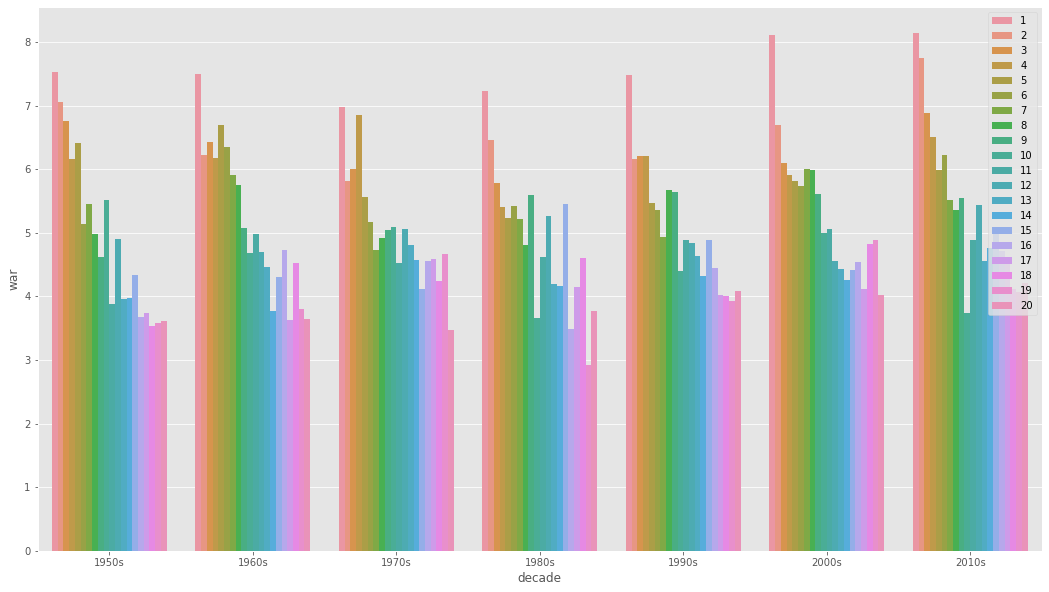

In [25]:
plt.figure(figsize=(18,10))
sns.barplot(x='decade', y='war', data=grouped_df, hue="voting_place")
plt.legend(loc='upper right')

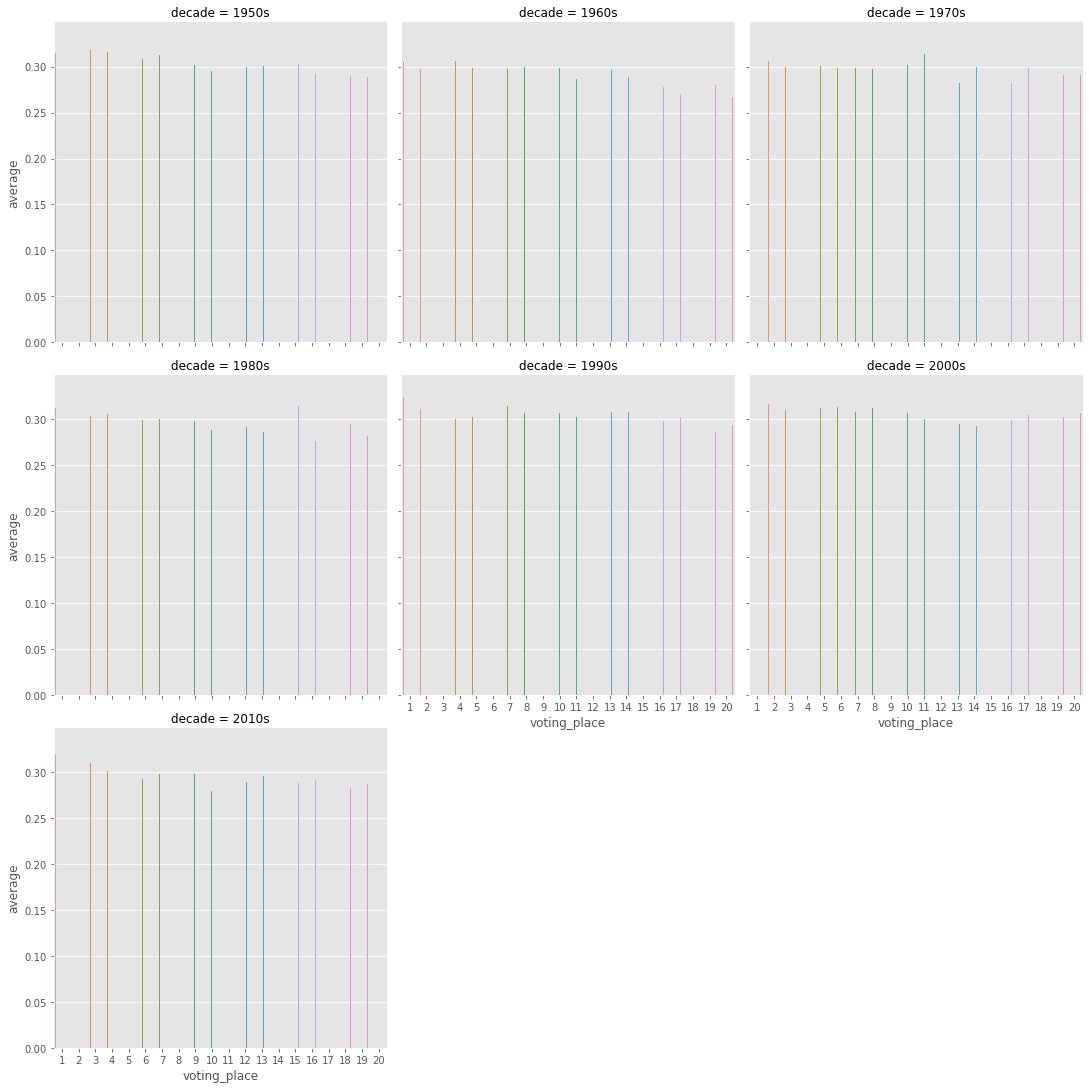

In [26]:
sns.catplot(x='voting_place', y='average', kind='bar', data=grouped_df, hue="voting_place",col='decade',col_wrap=3)

<AxesSubplot:xlabel='year', ylabel='home_runs'>

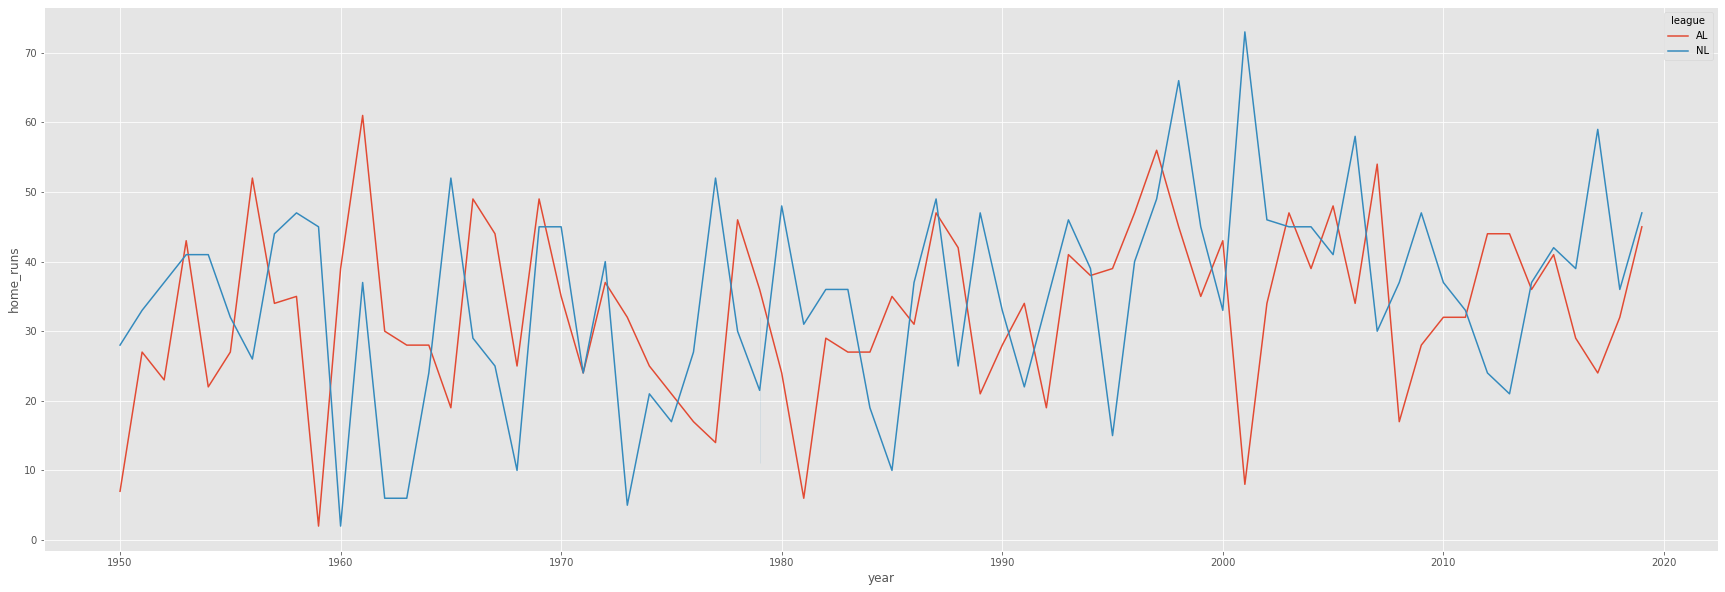

In [27]:
plt.figure(figsize=(30,10))
sns.lineplot(x='year', y='home_runs', data=df.loc[df.winner==True],hue='league')

In [72]:
group_cols = ['decade','playoffs','winner']
grouped_df = df[group_cols + stats + ['war_difference','home_runs_difference','rbi_difference']].groupby(group_cols).mean().reset_index()

In [69]:
grouped_df

,decade,playoffs,average,home_runs,rbi,runs,sb,obp,ops,slg,war,runs_produced,war_difference,home_runs_difference,rbi_difference
0,1950s,No,0.302776,20.094828,85.491379,89.784483,6.750000,0.379741,0.864431,0.484647,4.661207,155.181034,4.119828,21.922414,41.103448
1,1950s,Yes,0.289000,17.000000,75.093750,86.687500,8.812500,0.372500,0.830125,0.457531,4.875000,144.781250,3.900000,24.937500,52.031250
2,1960s,No,0.294574,22.704348,85.400000,87.052174,9.408696,0.364930,0.848313,0.483313,5.188696,149.747826,3.880000,22.634783,38.217391
3,1960s,Yes,0.293471,15.852941,71.323529,78.852941,11.088235,0.350206,0.795412,0.445324,4.488235,134.323529,4.526471,27.500000,52.088235
4,1970s,No,0.300427,20.072917,85.906250,84.343750,14.083333,0.371458,0.847792,0.476344,4.875000,150.177083,3.679167,19.739583,37.052083
5,1970s,Yes,0.292596,18.553191,83.255319,81.787234,10.574468,0.360787,0.824191,0.463362,4.627660,146.489362,4.010638,22.404255,43.085106
6,1980s,No,0.300491,22.990566,89.632075,90.132075,19.000000,0.369368,0.863000,0.493689,5.096226,156.773585,3.169811,17.528302,31.452830
7,1980s,Yes,0.286957,17.434783,76.978261,81.152174,16.652174,0.360522,0.814717,0.454174,3.943478,140.695652,4.376087,21.000000,40.478261
8,1990s,No,0.309762,27.038095,98.885714,93.990476,15.238095,0.384305,0.915362,0.530990,5.041905,165.838095,3.622857,19.638095,32.685714
9,1990s,Yes,0.297709,26.872727,99.563636,98.018182,15.436364,0.377309,0.895418,0.518127,4.845455,170.709091,4.043636,24.000000,41.545455


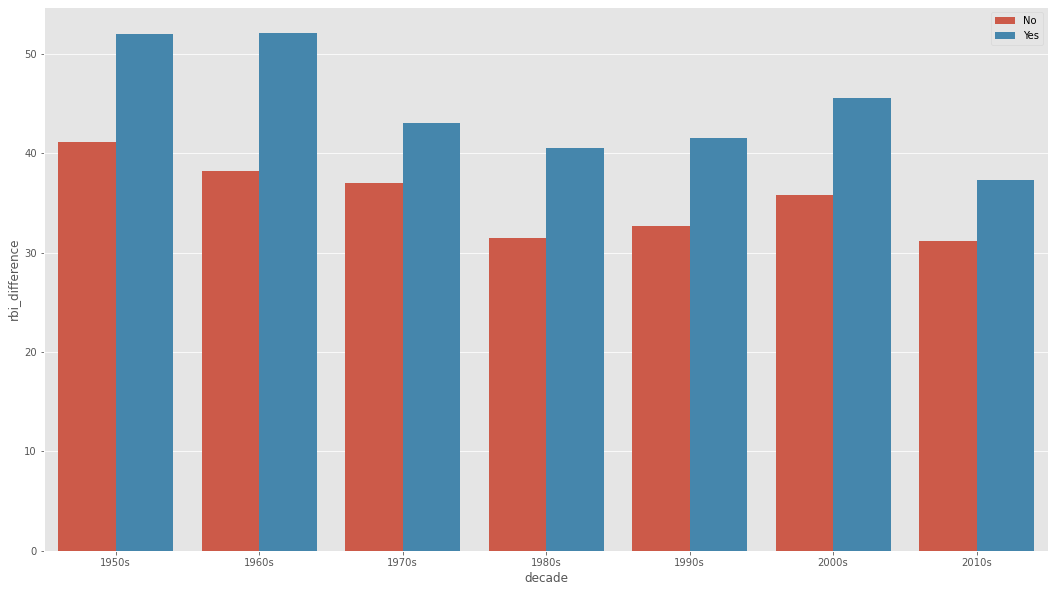

In [71]:
plt.figure(figsize=(18,10))
sns.barplot(x='decade', y='war_difference', data=grouped_df.loc[grouped_df.winner==True], hue="playoffs")
plt.legend(loc='upper right')

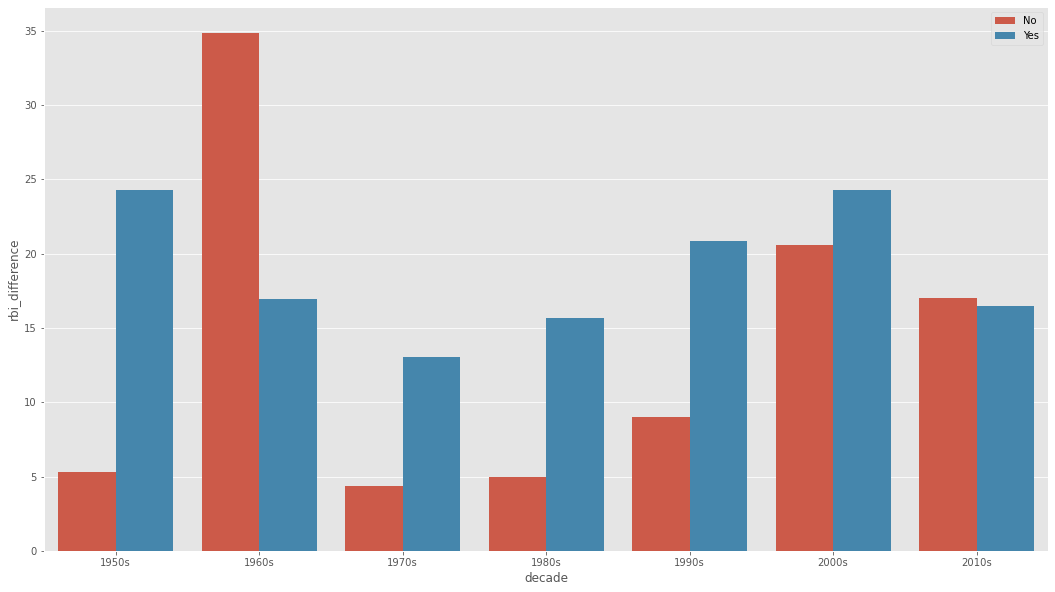

In [30]:
plt.figure(figsize=(18,10))
sns.barplot(x='decade', y='rbi_difference', data=grouped_df.loc[grouped_df.winner==True], hue="playoffs")
plt.legend(loc='upper right')

In [548]:
test = df[df['decade']=='1980s']
test = test[test['winner']==True]

In [549]:
test[['war_difference','year','name','playoffs']]

,war_difference,year,name,playoffs
0,0.0,1983,"Ripken,Cal",Yes
16,-0.3,1983,"Murphy,Dale",No
31,0.0,1982,"Yount,Robin",Yes
50,-2.5,1982,"Murphy,Dale",Yes
65,0.0,1981,"Henderson,Rickey",Yes
81,0.0,1981,"Schmidt,Mike",Yes
96,0.0,1980,"Brett,George",Yes
112,0.0,1980,"Schmidt,Mike",Yes
1514,-2.9,1989,"Yount,Robin",No
1528,-1.9,1989,"Mitchell,Kevin",Yes


In [1]:
# sns.catplot(x="decade", y="voting_place",
#                  col="metric",
#                 data=league_leaders_df[league_leaders_df['metric'].isin(['average','home_runs','rbi','runs_produced','obp','ops','war','team_wins','win_pct_improvement'])], kind="box",col_wrap=4,
#                 height=4, aspect=.7)